# Предсказание ядовитых грибов

**Цель-** предсказать, будет ли гриб съедобным или ядовитым, исходя из его физических характеристик.

Данные взяты из kaggle-соревнования [Binary Prediction of Poisonous Mushrooms.](https://www.kaggle.com/competitions/playground-series-s4e8)

Набор данных для этого соревнования (как обучающий, так и тестовый) был создан на основе модели глубокого обучения, обученной на наборе данных [UCI Mushroom.](https://archive.ics.uci.edu/dataset/73/mushroom). В данные добавлены переменные, которых не было в оригинальном наборе данных.

**Файлы**

- `train.csv` - обучающий набор данных
- `test.csv` - тестовый набор данных
- `sample_submission.csv` - образец файла для отправки в правильном формате

**Метрика** - Matthews correlation coefficient (MCC).

**Таргет** - class.

**Описание переменных**

- `cap-shape` -> форма шляпки: bell=b,conical=c,convex=x,flat=f, kbbed=k,sunken=s
- `cap-diameter` -> диаметр шляпки в см
- `cap-surface` -> поверхность шляпки: fibrous=f,grooves=g,scaly=y,smooth=s
- `cap-color` -> цвет шляпки: brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
- `does-bruise-bleed` ->  после срезания грибы покрываются синяками или "кровоточат": bruises-or-bleeding=t,no=f
- `gill-attachment` -> крепление пластинок: attached=a,descending=d,free=f,tched=n
- `gill-spacing` -> расстояние между пластинками: close=c,crowded=w,distant=d
- `gill-color` -> цвет пластинок: black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
- `stem-height` -> высота стебля в см
- `stem-width` -> толщина стебля в мм
- `stem-root` -> корень стебля
- `stem-surface` -> поверхность стебля
- `stem-color` -> цвет стебля
- `veil-type` -> тип покрова: partial=p,universal=u
- `veil-color` -> цвет покрова: brown=n,orange=o,white=w,yellow=y
- `has-ring` -> наличие кольца
- `ring-type` -> тип кольца: cobwebby=c,evanescent=e,flaring=f,large=l, ne=n,pendant=p,sheathing=s,zone=z
- `spore-print-color` -> цвет спор: black=k,brown=n,buff=b,chocolate=h,green=r, orange=o,purple=u,white=w,yellow=y
- `habitat` -> среда обитания: grasses=g,leaves=l,meadows=m,paths=p, urban=u,waste=w,woods=d
- `season` -> сезон: spring=s, summer=u, autumn=a, winter=w

**План исследования**

1. Изучение данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Обучение базовых моделей
6. Глубокое обучение
7. Общий вывод

У нас очень много признаков, но среди них можно сразу выделить наиболее важные:

- `cap-color` (цвет шляпки) - Некоторые цвета шляпок грибов могут быть более характерны для ядовитых видов.
- `does-bruise-bleed` (покрываются синяками или "кровоточат") - Признак, который напрямую может свидетельствовать о наличии ядовитых веществ.
- `gill-color` (цвет пластинок) - Цвет пластинок может варьироваться между ядовитыми и съедобными видами.
- `spore-print-color` (цвет спор) - Цвет спорового отпечатка часто используется для идентификации вида гриба.
- `habitat` (среда обитания) - Некоторые ядовитые грибы растут в определенных условиях.
- `season` (сезон) — время года может быть важным фактором, поскольку некоторые ядовитые грибы появляются только в определенные сезоны.
- `cap-surface` (поверхность шляпки) — текстура шляпки, такая как чешуйчатость, может быть связана с ядовитостью.

Как по мне это наиболее важные признаки, поэтому в первую очередь будем обращать внимание на них.


# Изучение данных
## Импорт библиотек

In [1]:
import os
import warnings
import gc
from math import ceil

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import shapiro

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import matthews_corrcoef, accuracy_score

from tqdm.notebook import tqdm
import statsmodels.api as sm

import phik
from phik.report import plot_correlation_matrix

from lightgbm import LGBMClassifier

import torch
import torch.nn as nn
import torchmetrics

In [87]:
%matplotlib inline
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
pd.options.display.float_format ='{:,.3f}'.format

warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

## Функции

In [3]:
def replace_unknown_val(data):
    '''
    Функция принимает датафрейм. Генерирует 
    список букв алфавита. Заменяет неизвестные категории 
    в столбце, если категория совпадает с буквой алфавита
    то оставляет ее в противном случаем заменяет значение 
    на моду этого столбца.
    '''

    # Генерируем список букв английского алфавита
    alphabet = [chr(i) for i in range(97, 123)]

    # Создаем список категориальных столбцов
    columns_cat = data.select_dtypes(include='category').columns.to_list()

    # Меняем значения в цикле
    for columns in columns_cat:
        data[columns] = data[columns].apply(
            lambda x: x if x in alphabet else data[columns].mode().to_list()[0]).astype('category')

    return data

In [4]:
def test_shapiro_qq(data, alpha):
    '''
    Функция проверяет данные на нормальное
    распределени, используя тест Шапиро-Уилка и
    строит график QQ-plot. Принимает столбец и 
    сверяет его p-value с уровнем статистической 
    значимости, выводит ответ о нормальности и график.
    '''
    
    stat, p = shapiro(data)
    
    if p > alpha:
        print('Не отвергаем H0. Данные получены из нормального распределения')
    else:
        print('Отвегаем H0 и принимаем H1. \
Данные не получены из нормального распределения')
        
    sm.qqplot(data, line='s')
    plt.title(f'QQ-plot {data.name}')

## Константы

In [4]:
# Указываем путь к файлам
PTH1 = r"C:\Users\stepa\Downloads\train.csv"
PTH2 = r"C:\Users\stepa\Downloads\test.csv"
PTH3 = r"C:\Users\stepa\Downloads\sample_submission.csv"

ALPHA = 0.05
RANDOM_STATE = 42
TEST_SIZE = 0.25

## Загрузка данных

In [5]:
if os.path.exists(PTH1):
    df_train = pd.read_csv(PTH1)
else:
    print('Файл не найден')

In [6]:
if os.path.exists(PTH2):
    df_test = pd.read_csv(PTH2)
else:
    print('Файл не найден')

Выведем первые 5 строк датасетов

In [8]:
df_train.head()  # Выводим первые 5 строк

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.800,f,s,u,f,a,c,w,4.510,15.390,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.510,x,h,o,f,a,c,n,4.790,6.480,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.940,f,s,b,f,x,c,w,6.850,9.930,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.880,f,y,g,f,s,NaN,g,4.160,6.530,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.850,x,l,w,f,d,NaN,w,3.370,8.360,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [9]:
df_train.shape  # Смотрим размер

(3116945, 22)

In [10]:
df_test.head()  # Выводим первые 5 строк

,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,3116945,8.640,x,NaN,n,t,NaN,NaN,w,11.130,17.120,b,NaN,w,u,w,t,g,NaN,d,a
1,3116946,6.900,o,t,o,f,NaN,c,y,1.270,10.750,NaN,NaN,n,NaN,NaN,f,f,NaN,d,a
2,3116947,2.000,b,g,n,f,NaN,c,n,6.180,3.140,NaN,NaN,n,NaN,NaN,f,f,NaN,d,s
3,3116948,3.470,x,t,n,f,s,c,n,4.980,8.510,NaN,NaN,w,NaN,n,t,z,NaN,d,u
4,3116949,6.170,x,h,y,f,p,NaN,y,6.730,13.700,NaN,NaN,y,NaN,y,t,NaN,NaN,d,u


In [11]:
df_test.shape  # Смотрим размер

(2077964, 21)

уже можно отметить, что есть пустые значения. Теперь посмотрим на общую информацию о данных в таблицах.

In [12]:
df_train.info()  # Выводим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [13]:
df_train.describe()  # Выводим описательную статистику

,id,cap-diameter,stem-height,stem-width
count,"3,116,945.000","3,116,941.000","3,116,945.000","3,116,945.000"
mean,"1,558,472.000",6.310,6.348,11.154
std,"899,784.662",4.658,2.700,8.095
min,0.000,0.030,0.000,0.000
25%,"779,236.000",3.320,4.670,4.970
50%,"1,558,472.000",5.750,5.880,9.650
75%,"2,337,708.000",8.240,7.410,15.630
max,"3,116,944.000",80.670,88.720,102.900


Рассмотрим полученную информацию подробнее.

Всего в таблице 22 столбца, тип данных - `int`(1), `object`(18), `float`(3). Исходя из описательной статистики на первый взгляд данные выглядят без выбросов, так как среднее и медиана практически совпадают. Также максимальные и минимальные значения не выглядет аномально.

In [14]:
df_test.info()  # Выводим информацию о df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   cap-diameter          float64
 2   cap-shape             object 
 3   cap-surface           object 
 4   cap-color             object 
 5   does-bruise-or-bleed  object 
 6   gill-attachment       object 
 7   gill-spacing          object 
 8   gill-color            object 
 9   stem-height           float64
 10  stem-width            float64
 11  stem-root             object 
 12  stem-surface          object 
 13  stem-color            object 
 14  veil-type             object 
 15  veil-color            object 
 16  has-ring              object 
 17  ring-type             object 
 18  spore-print-color     object 
 19  habitat               object 
 20  season                object 
dtypes: float64(3), int64(1), object(17)
memory usage: 332.9+ MB


In [15]:
df_test.describe()  # Выводим описательную статистику

,id,cap-diameter,stem-height,stem-width
count,"2,077,964.000","2,077,957.000","2,077,963.000","2,077,964.000"
mean,"4,155,926.500",6.306,6.347,11.148
std,"599,856.682",4.685,2.699,8.100
min,"3,116,945.000",0.000,0.000,0.000
25%,"3,636,435.750",3.310,4.670,4.970
50%,"4,155,926.500",5.740,5.880,9.640
75%,"4,675,417.250",8.230,7.410,15.620
max,"5,194,908.000",607.000,57.290,102.910


Рассмотрим полученную информацию подробнее.

Всего в таблице 21 столбец, тип данных - `int`(1), `object`(17), `float`(3). Исходя из описательной статистики, в тестовом датафрейме не нравится минимальные значения. Медиана и среднее также практически равны.

## Вывод

Каждая строка таблиц содержит информацию о грибе. Необходимо сделать проверку данных:

- Так как первичное исследование показало, что есть в данных пустые значения. Необходимо поработать с ними и по возможности заполнить.
- Сделать проверку на явные и неявные дубликаты и исправить их, если они будут найдены.
- Изменить типы данных для эффективного управления памятью

# Предобработка данных
## Изменение типов данных

Так как у нас очень много значений, важно использовать эффективно память компьютера. Для этого изменим типы данных

In [7]:
# Изменяем тип данных в категориальных данных
df_train[df_train.select_dtypes(include='object').columns] = df_train.select_dtypes(
    include='object').astype('category')

# Изменяем тип данных в количественных данных
df_train['id'] = df_train['id'].astype('int32')
df_train['cap-diameter'] = df_train['cap-diameter'].astype('float32')
df_train['stem-height'] = df_train['stem-height'].astype('float32')
df_train['stem-width'] = df_train['stem-width'].astype('float32')

In [8]:
# Изменяем тип данных в категориальных данных
df_test[df_test.select_dtypes(include='object').columns] = df_test.select_dtypes(
    include='object').astype('category')

# Изменяем тип данных в количественных данных
df_test['id'] = df_train['id'].astype('int32')
df_test['cap-diameter'] = df_test['cap-diameter'].astype('float32')
df_test['stem-height'] = df_test['stem-height'].astype('float32')
df_test['stem-width'] = df_test['stem-width'].astype('float32')

Посмотрим насколько удалось уменьшить потребление памяти

In [18]:
df_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Columns: 22 entries, id to season
dtypes: category(18), float32(3), int32(1)
memory usage: 101.1 MB


In [19]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2077964 entries, 0 to 2077963
Columns: 21 entries, id to season
dtypes: category(17), float32(3), int32(1)
memory usage: 65.4 MB


Удалось в 5 раз уменьшить количество потребляемой памяти

## Работа с пропусками

Теперь можно приступить к работе с пропусками.

In [20]:
count_na = pd.Series(df_train.isna().sum(), name='Пропуски')

In [21]:
proportion_na = pd.Series(
    (df_train.isna().sum() / len(df_train)) * 100, name='Доля')

In [22]:
pd.concat([count_na, proportion_na], axis=1).sort_values(
    by='Доля', ascending=False)

,Пропуски,Доля
veil-type,2957493,94.884
spore-print-color,2849682,91.425
stem-root,2757023,88.453
veil-color,2740947,87.937
stem-surface,1980861,63.551
gill-spacing,1258435,40.374
cap-surface,671023,21.528
gill-attachment,523936,16.809
ring-type,128880,4.135
gill-color,57,0.002


Раннее отметили наиболее важные признаки и, к сожалению, в одном из них очень много пропусков - 91% (spore-print-color). Как-то восстановить пропуски в таком большом количестве не удастся, а заполнение их заглушкой может только повлиять на результаты модели. Поэтому признаки, у которых доля пропусков больше 50% мы удалим и использовать не будем. 

In [23]:
count_na = pd.Series(df_test.isna().sum(), name='Пропуски')

In [24]:
proportion_na = pd.Series(
    (df_test.isna().sum() / len(df_test)) * 100, name='Доля')

In [25]:
pd.concat([count_na, proportion_na], axis=1).sort_values(
    by='Доля', ascending=False)

,Пропуски,Доля
veil-type,1971545,94.879
spore-print-color,1899617,91.417
stem-root,1838012,88.453
veil-color,1826124,87.880
stem-surface,1321488,63.595
gill-spacing,839595,40.405
cap-surface,446904,21.507
gill-attachment,349821,16.835
ring-type,86195,4.148
gill-color,49,0.002


In [9]:
# Выписываем столбцы для удаления
columns_drop = ['veil-type', 'spore-print-color',
                'stem-root', 'veil-color', 'stem-surface']

In [10]:
df_train = df_train.drop(columns=columns_drop, axis=1)  # Удаляем столбцы

In [11]:
df_test = df_test.drop(columns=columns_drop, axis=1)  # Удаляем столбцы

Так как нам необходимо предсказать для всех значений из тестового датафрейма, то удалять из него значения мы не можем. На данном этапе пропуски трогать больше не будем, так как, возможно, получиться заполнить их, но для этого необходимо провести исследовательский анализ. Теперь разберемся с дубликатами. 

## Работа с явными дубликатами

In [29]:
df_train.duplicated().sum()  # Считаем количество дубликатов

0

In [30]:
df_test.duplicated().sum()  # Считаем количество дубликатов

0

Ни в одном датасете дубликатов не обнаружено

## Работа с неявными дубликатами

Проверим категориальные столбцы на наличие неявных дубликатов. Возможно в этих столбцах одно и то же значение написано с разным регистром или же есть лишние пробелы. Также одно и то же значение может быть написано по-разному.

Начнем с тренировочного набора.

In [31]:
df_train.select_dtypes(include='category').columns 

Index(['class', 'cap-shape', 'cap-surface', 'cap-color',
       'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color',
       'stem-color', 'has-ring', 'ring-type', 'habitat', 'season'],
      dtype='object')

In [32]:
df_train['season'].value_counts()  # Выводим количество уникальных значений

season
a    1543321
u    1153588
w     278189
s     141847
Name: count, dtype: int64

In [33]:
df_train['habitat'].value_counts()  # Выводим количество уникальных значений

habitat
d                       2177573
g                        454908
l                        171892
m                        150969
h                        120137
w                         18530
p                         17180
u                          5264
e                            55
s                            52
n                            41
t                            40
r                            38
y                            34
a                            34
k                            31
c                            26
b                            18
o                            12
f                            11
i                             7
x                             5
habitat                       5
z                             5
class                         3
spore-print-color             3
ring-type                     2
veil-type                     1
is w                          1
is h                          1
1.66                          1


Видно, что есть множество значений, которые не соответствуют информацией про этот признак. Поэтому я пошел более детально изучать эту проблему. Просмотрев все обсуждения данного соревнования, увидел что многие просто оставляют эти значения как есть. Я предположил следующие, так как набор данных был синтетически сделан на основе другого набора данных, при этом известно, что добавлены признаки, которые не существуют в оригинальном наборе данных, также стоит учитывать, что описание данных есть только у оригинального набора данных. То можно предположить, что помимо новых признаков, также были добавлены новые категории, поэтому значения, которые являются одной из букв английского алфавита будем считать новой категорией, которую добавили создатели данного набора данных. Все остальные значения, если не получиться понять, как их изменить будут заменены на "моду" этого признака.

Так как скорее всего во всех категориальных переменных такая ситуация, то сразу исправим ее во всех столбцах, для этого написали функцию `replace_unknown_val`.

In [12]:
df_train = replace_unknown_val(df_train)

In [13]:
df_test = replace_unknown_val(df_test)

In [36]:
df_train['habitat'].value_counts()  # Выводим количество уникальных значений

habitat
d    2177611
g     454908
l     171892
m     150969
h     120137
w      18530
p      17180
u       5264
e         55
s         52
n         41
t         40
r         38
y         34
a         34
k         31
c         26
b         18
o         12
f         11
i          7
x          5
z          5
Name: count, dtype: int64

Замена удалась, а значит неявных дубликатов нет.

## Вывод

На данном этапе были сделаны следующие действия:

- Изменили типы данных для эффективного управления памятью. В результате удалось уменьшить потребление память в 5 раз.
- Сделали проверку на пропуски в данных. В результате увидели, что есть столбцы, у которых доля пропусков составляет больше 90%. Решили, что если доля пропусков больше 50%, то такие признаки мы удалим, так как восстановить данные не получиться, а заполнять их заглушкой нецелесообразно. Удалили 5 столбцов. Остальные пропуски пока оставили без изменений, так как, возможно, их получиться заполнить, если провести анализ.
- Сделали проверку на явные дубликаты. В результате они не были обнаружены.
- Сделали проверку на неявные дубликаты в категориальных столбцах. В результате проверки было обнаружено, что в данных есть множество категорий, которых не было в оригинальном датафрейме. Предположили, что, так как данные синтетические и были добавлены новые признаки, могли добавить и новые категории. Так как категории соответствуют буквам английского алфавита, то значения, которые не являются этими буквами заменяли на "моду" этого признака, для этого написали функцию `replace_unknown_val`.

# Исследовательский анализ данных

Исследуем данные в датафрейме train_df:

- Посмотрим на соотношение целевого признака - class
- Посмотрим на соотношение остальных категориальных данных, построим scatterplot'ы, возможно получиться разбить данные на кластеры и таким образом заполнить пропуски.
- Изучим количественные переменные: `cap-diameter`, `stem-height`, `stem-width'` в зависимости от таргета.


В данном случае для тестового набора данных проводить анализ не будем, так как этот набор данных является выборкой из тренировочного, а следовательно, имеет такие же свойства, как и у тренировочного, так как выборка репрезентативна.

Начнем с таргета

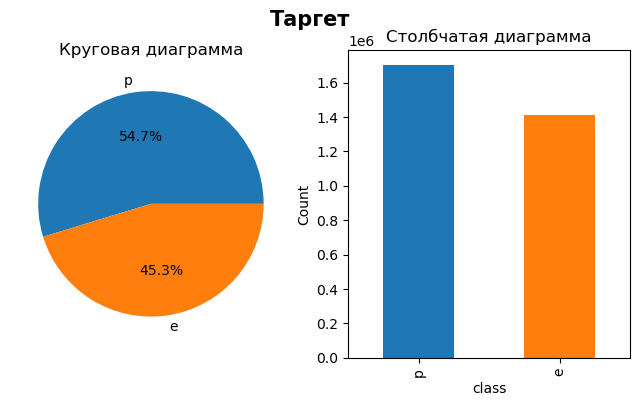

In [37]:
plt.figure(figsize=(8, 4))

plt.suptitle('Таргет', fontsize=15, fontweight='bold')

plt.subplot(1, 2, 1)
plt.pie(df_train['class'].value_counts().values, labels=df_train['class'].value_counts().index,
        autopct='%.1f%%')
plt.title('Круговая диаграмма')

plt.subplot(1, 2, 2)
df_train['class'].value_counts().plot(kind='bar', color=mcolors.TABLEAU_COLORS)
plt.ylabel('Count')
plt.title('Столбчатая диаграмма')

plt.show()

В целом соотношение таргета одинаково и достаточно будет при разбиение воспользоваться стратификацией.

Так как количественных переменных мало то категориальные будем исследовать в самом конце.

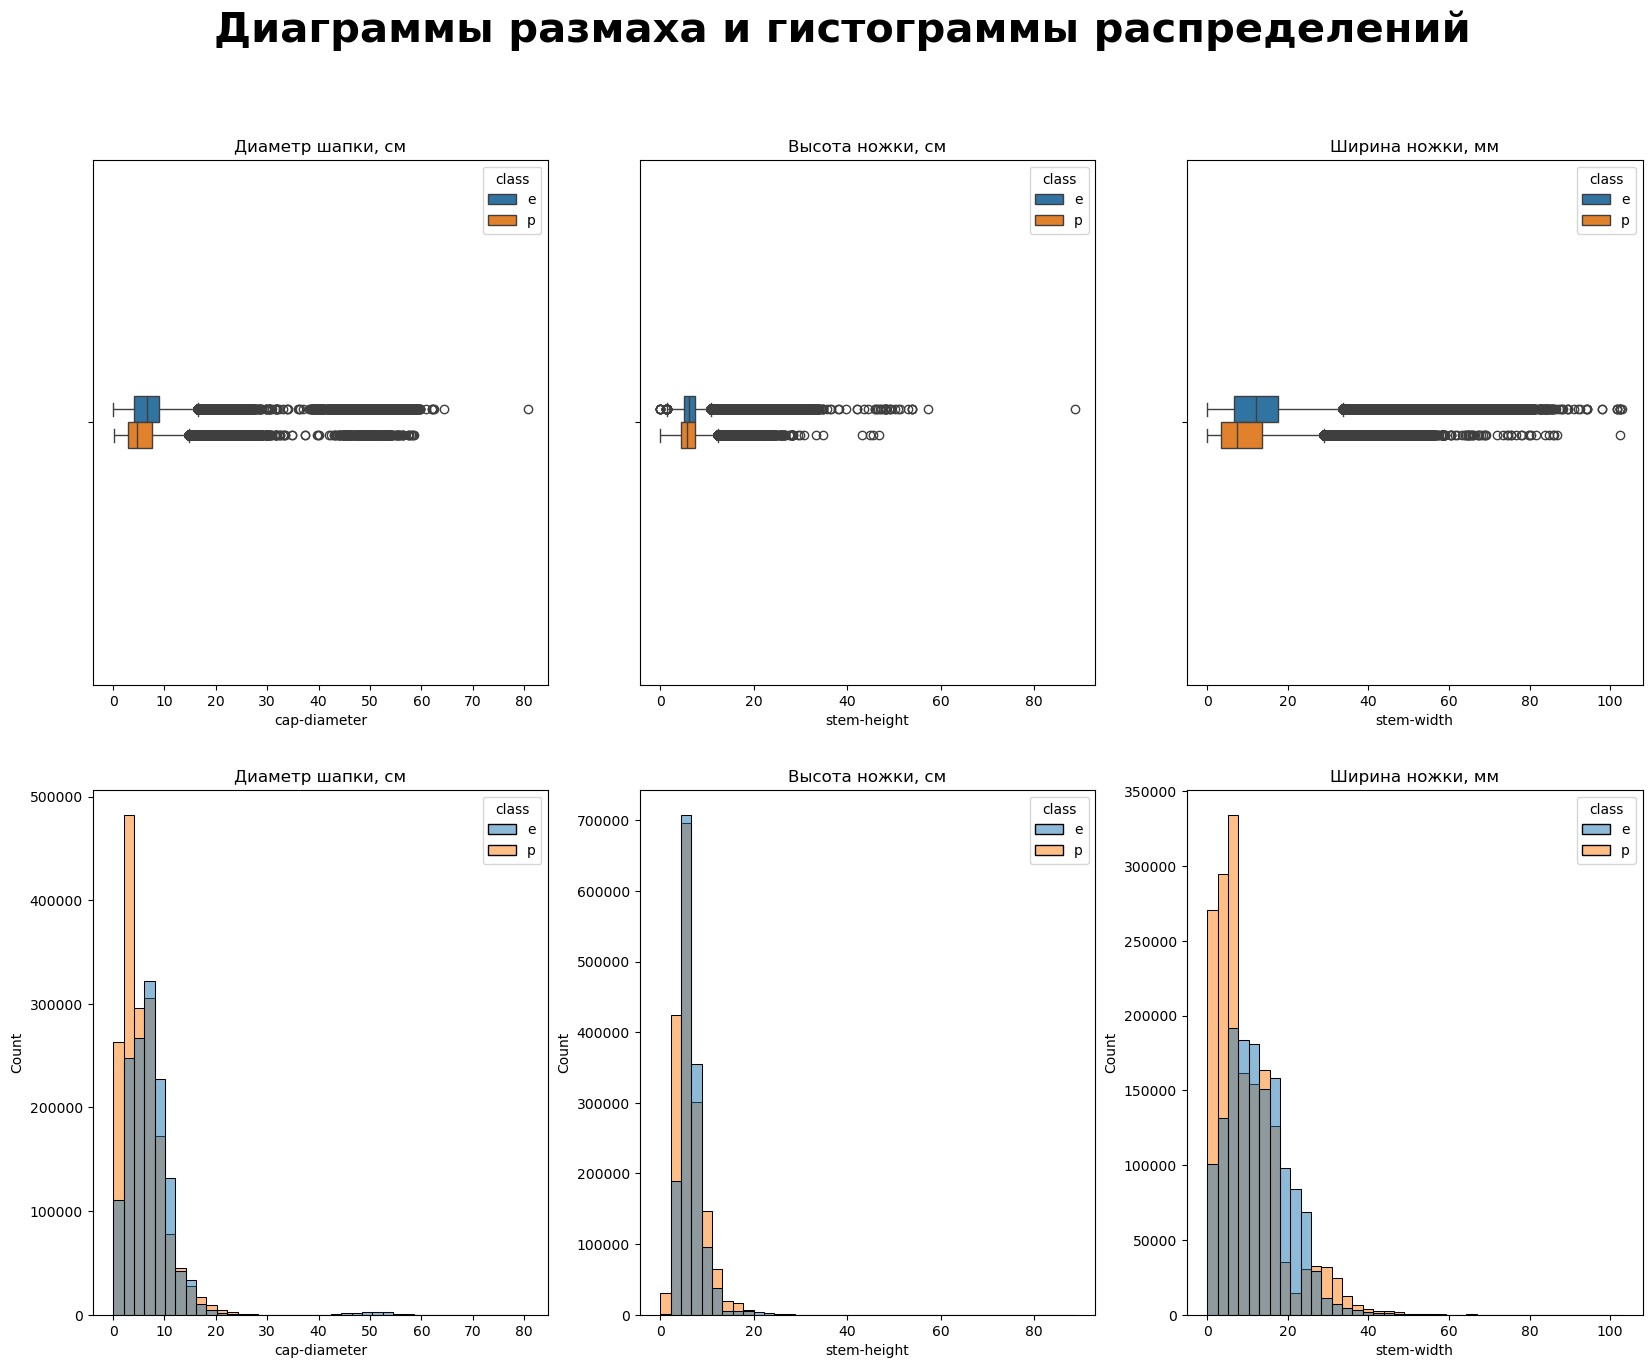

In [38]:
plt.figure(figsize=(20, 15))

plt.suptitle('Диаграммы размаха и гистограммы распределений',
             fontsize=30, fontweight='bold')

plt.subplot(2, 3, 1)
sns.boxplot(x=df_train['cap-diameter'], hue=df_train['class'], width=.1)
plt.title('Диаметр шапки, см')

plt.subplot(2, 3, 2)
sns.boxplot(x=df_train['stem-height'], hue=df_train['class'], width=.1)
plt.title('Высота ножки, см')

plt.subplot(2, 3, 3)
sns.boxplot(x=df_train['stem-width'], hue=df_train['class'], width=.1)
plt.title('Ширина ножки, мм')

plt.subplot(2, 3, 4)
sns.histplot(data=df_train, x='cap-diameter', hue='class', bins=40)
plt.title('Диаметр шапки, см')

plt.subplot(2, 3, 5)
sns.histplot(data=df_train, x='stem-height', hue='class', bins=40)
plt.title('Высота ножки, см')

plt.subplot(2, 3, 6)
sns.histplot(data=df_train, x='stem-width', hue='class', bins=40)
plt.title('Ширина ножки, мм')

plt.show()

Значения диаметра, высоты и ширины шапки очень необычные. Посмотрев информацию в интернете выяснил, что в среднем высота ножки гриба составляет 10-15 см, но у таких грибов, как мухомор порфировый (Amanita porphyria) и рядовка гигантская (Tricholoma colossus), ножка может достигать 25 см в высоту. Видно, что есть очень большие значения, но как выяснилось в интернете высота более 90 см также возможна, но это крайне редко. Некоторые виды тропических грибов, например, термитомицес титановый (Termitomyces titanicus), могут иметь ножки высотой до метра или более.


Также узнал, что ширина ножки обычно не превышает 10-20 мм, но диаметр ножки гриба-дождевика гигантского (Calvatia gigantea) может достигать 30–50 мм. Ширина ножки также может быть, как значения, которые мы видим на графиках. И может превышать 100 мм. Это возможно у крупных грибов, таких как белый гриб (Boletus edulis), особенно у старых и развитых экземпляров.

С диаметром шапки гриба сложнее, так как может варьироваться в широких пределах в зависимости от вида гриба и условий его произрастания. Например, диаметр шляпки белого гриба обычно составляет 10–25 см, а диаметр мухомора — 8–20 см. Есть грибы с более крупными шляпками. Диаметр некоторых видов грибов может достигать 50 см и более. Также узнал, что диаметр шапки гриба может быть больше 80 см, но это очень редко. Например, гигантские дождевики (Calvatia gigantea) могут достигать таких размеров. Эти грибы могут вырастать до гигантских размеров, и их диаметр может превышать 1 метр.

Так как такие значения судя по всему возможны, но являются крайне редкими. Необходимо посмотреть сколько таких грибов есть в датасете, если их много, то все же будем считать их аномальными. И тогда я предполагаю, что возможно такие большие значения были указаны в мм и поэтому мы просто поделим все аномальные значения на 10, чтобы привести их к реальным значениям.

In [39]:
(len(df_train[df_train['cap-diameter'] > 25]) / len(df_train)) * 100

0.4412654057097574

In [40]:
(len(df_train[df_train['stem-height'] > 25]) / len(df_train)) * 100

0.049439435087882524

In [41]:
(len(df_train[df_train['stem-width'] > 50]) / len(df_train)) * 100

0.09576684862902618

В целом таких значений очень, а значит их не будем считать аномальными и оставим их. 

Осталось только доказать статистически, что наши данные распределены ненормально. Для этого воспользуемся статистическим тестом Шапиро-Уилка, а также построим график QQ-plot, для этого была написана функция `test_shapiro_qq`.

Выдвинем гипотезы о нормальности:

- **H0** - данные получены из нормального распределения
- **H1** - данные не получены из нормального распределения

Предположим, что верна H0, тогда 

Не отвергаем H0. Данные получены из нормального распределения


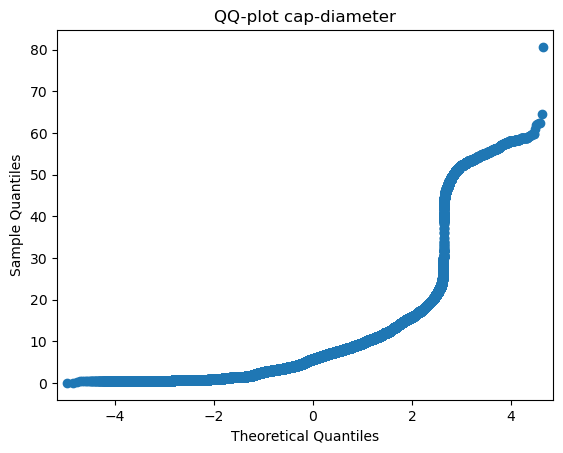

In [42]:
test_shapiro_qq(df_train['cap-diameter'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


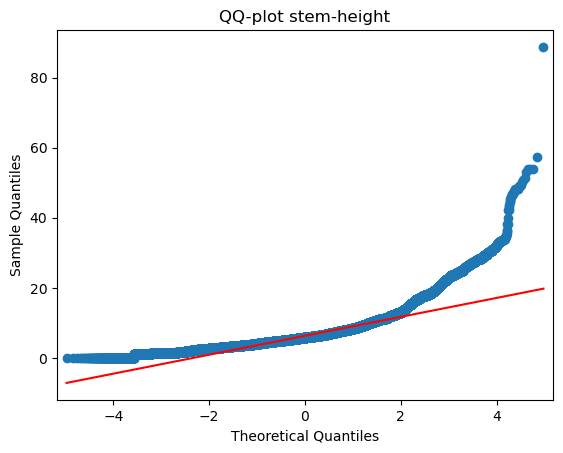

In [43]:
test_shapiro_qq(df_train['stem-height'], ALPHA)

Отвегаем H0 и принимаем H1. Данные не получены из нормального распределения


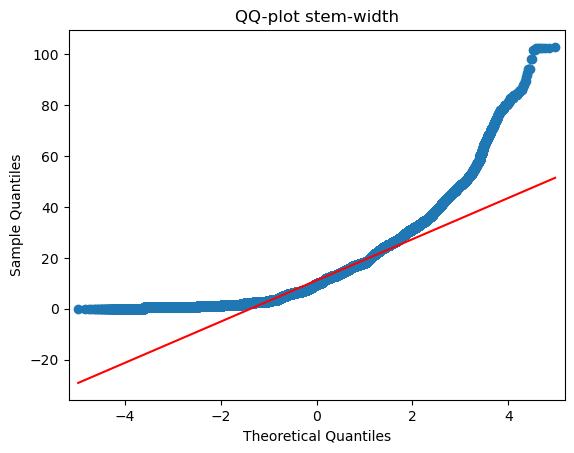

In [44]:
test_shapiro_qq(df_train['stem-width'], ALPHA)

Неожиданный вариант для `cap-diameter` тест показывает, что данные распределены нормально, возможно это связано с тем, что значений больше 5000 (согласно документации, если значений больше 5000 то могут быть ошибки) Но мы также построили QQ-plot на котором видно, что данные распределены ненормально, а значит все же все наши данные распределены ненормально.

Приступим к исследованию категориальных данных. И для каждой из них построим scatterplot, где по оси x будет диаметр шапки, а по оси y - высота ножки. Так мы попроубем найти закономерности в данных и благодаря этому заполним пропуски.

  0%|          | 0/12 [00:00<?, ?it/s]

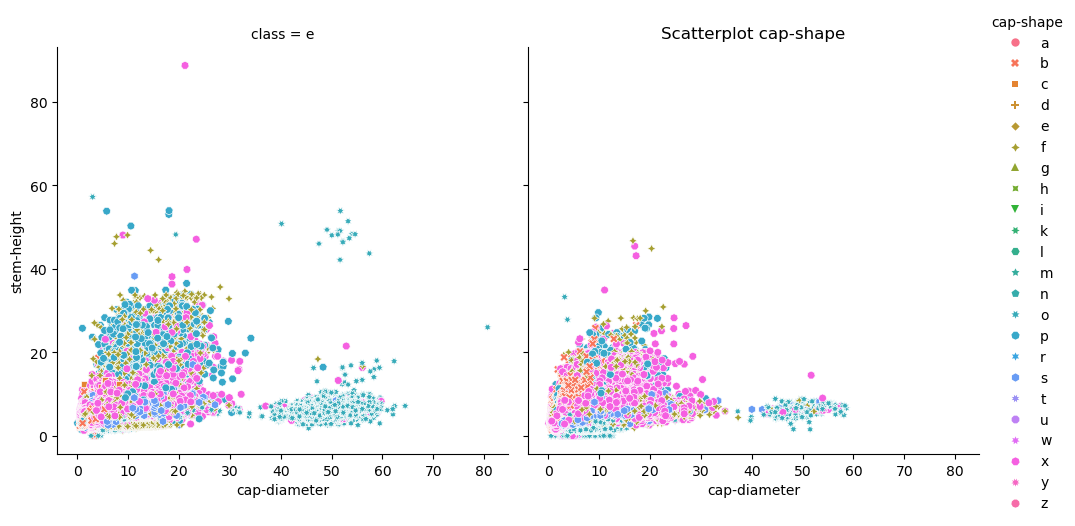

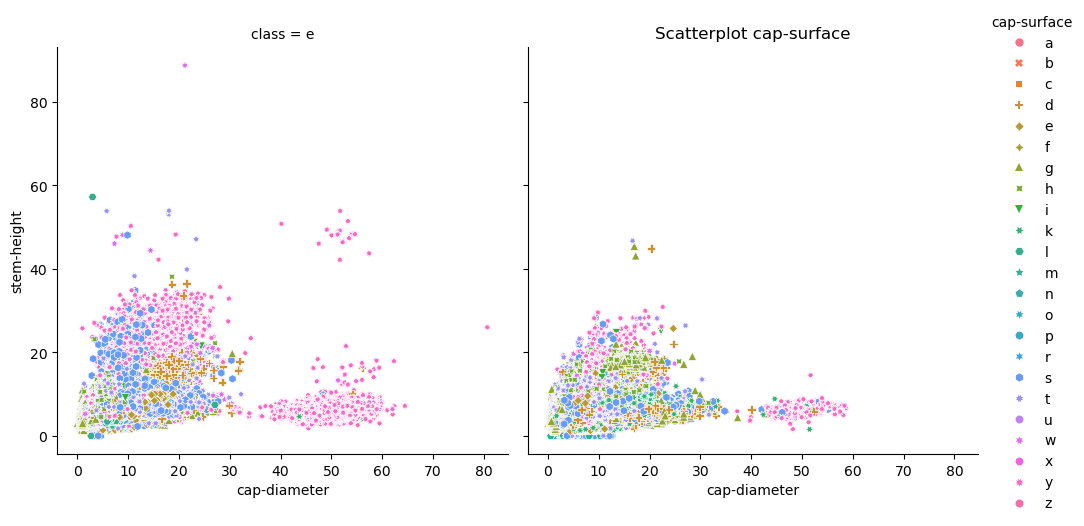

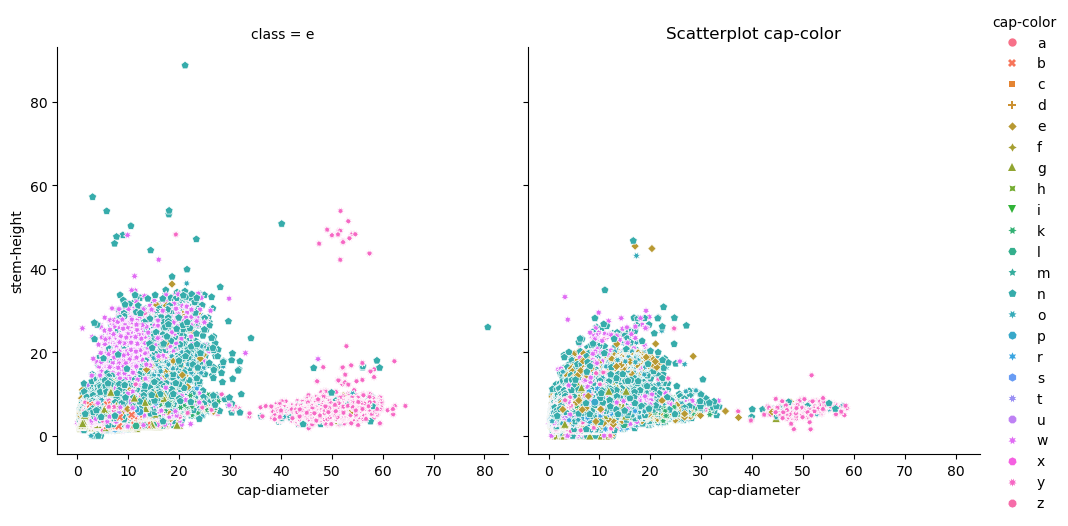

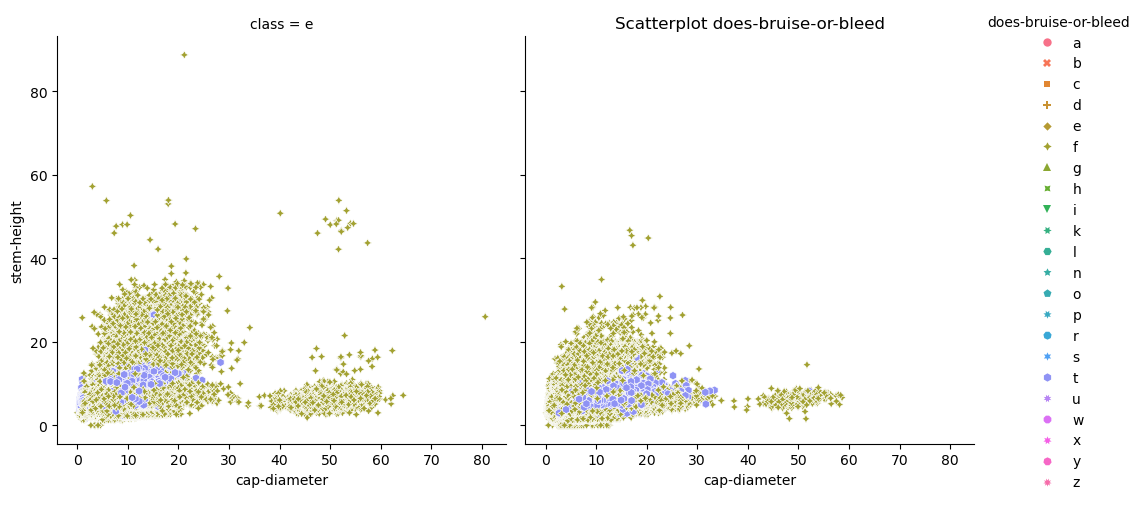

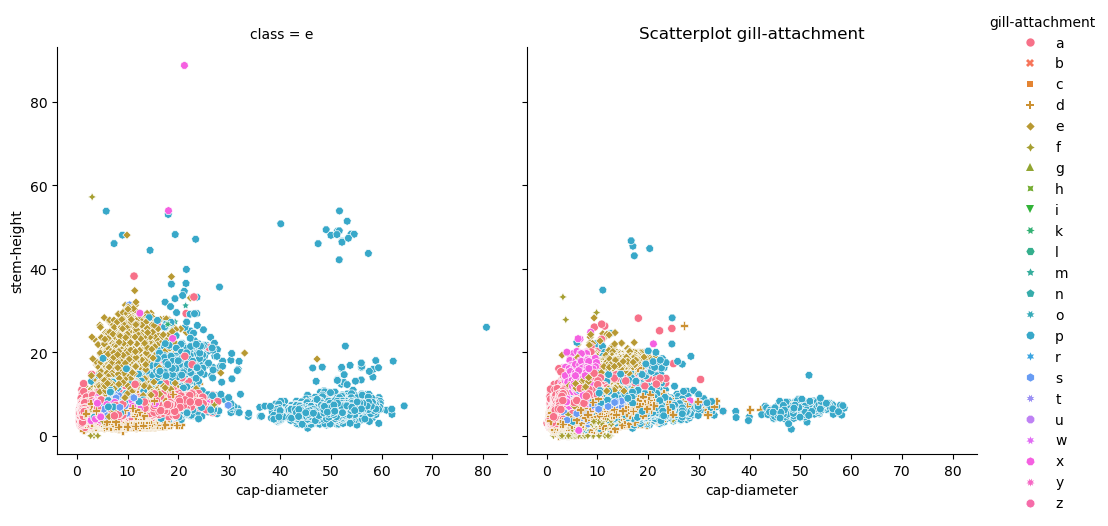

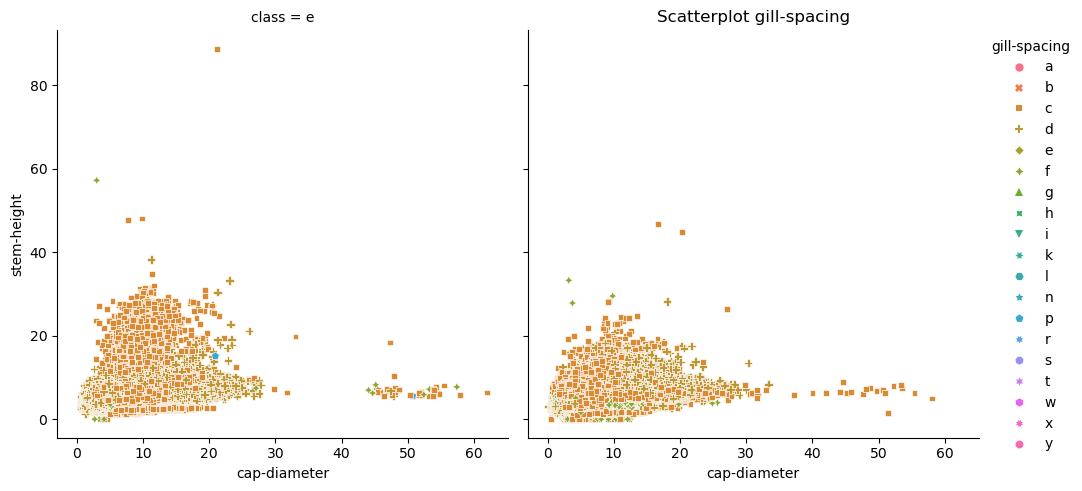

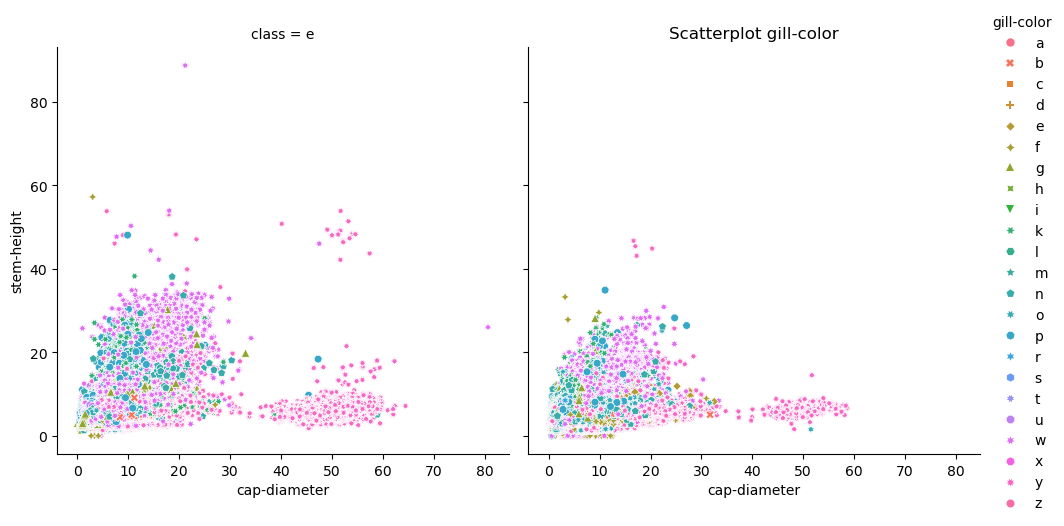

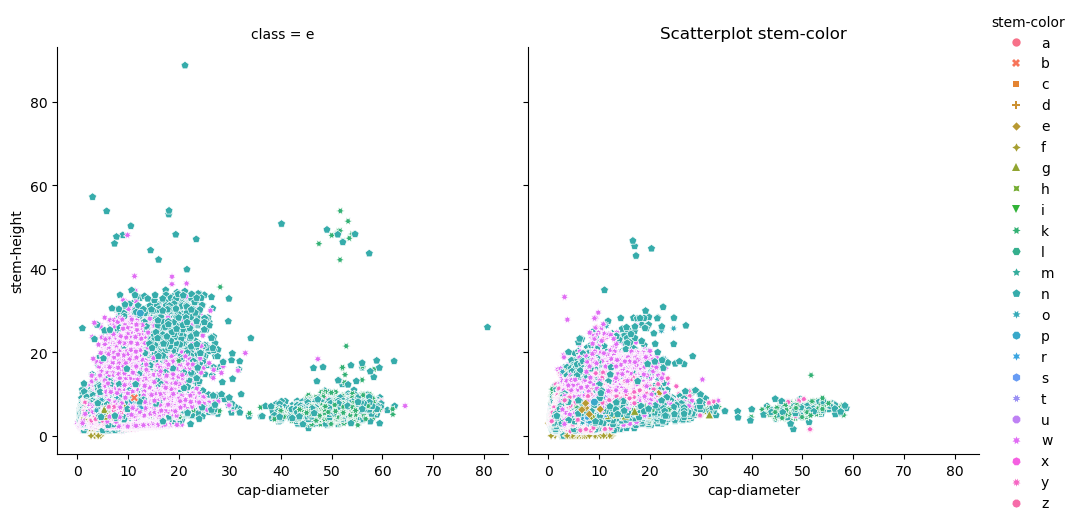

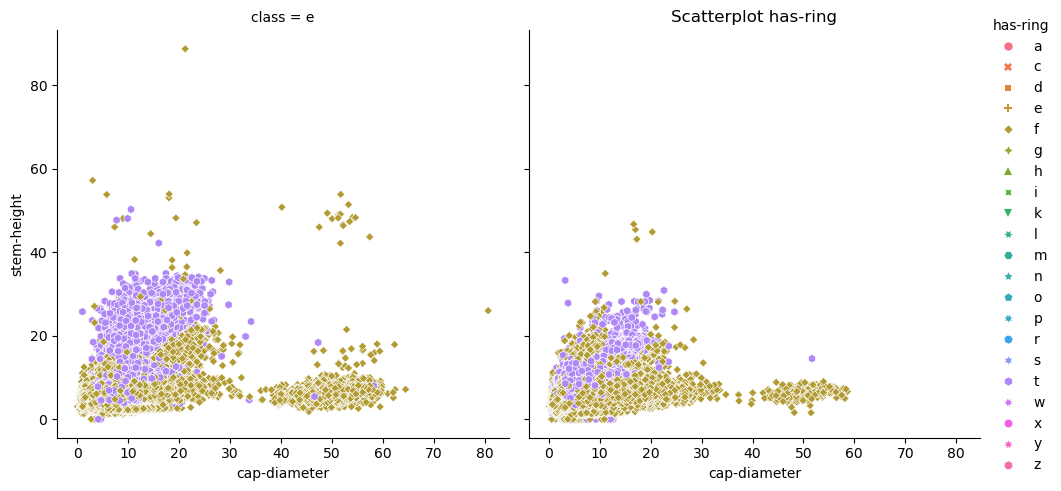

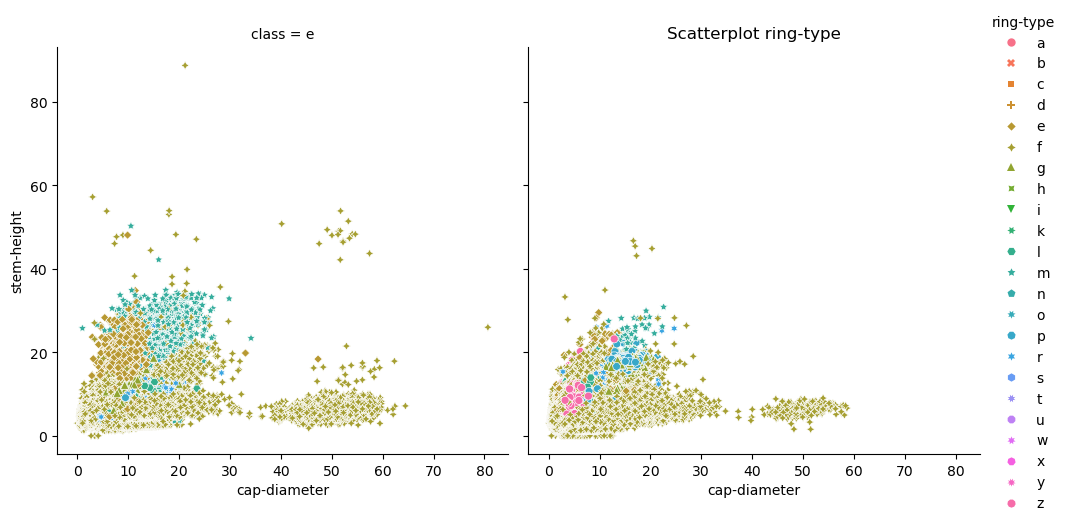

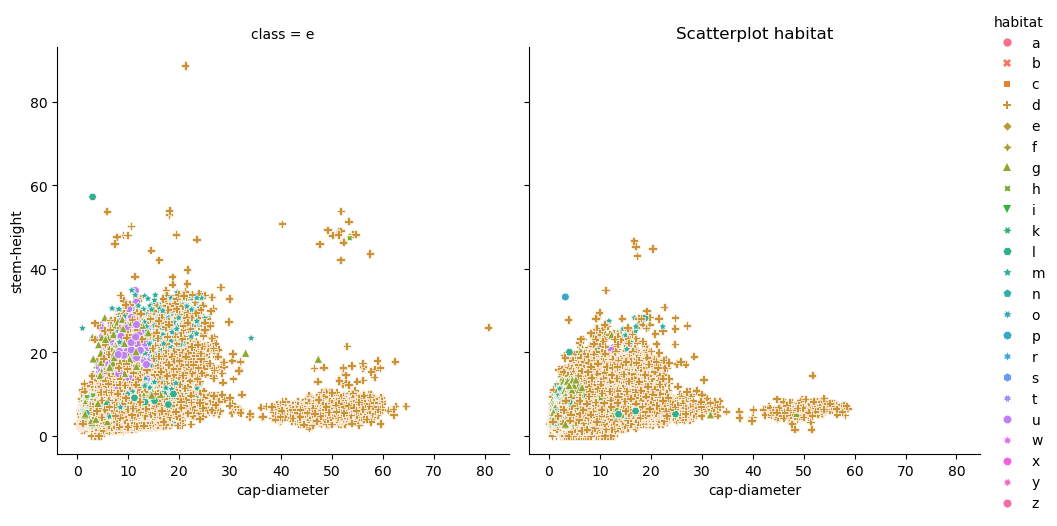

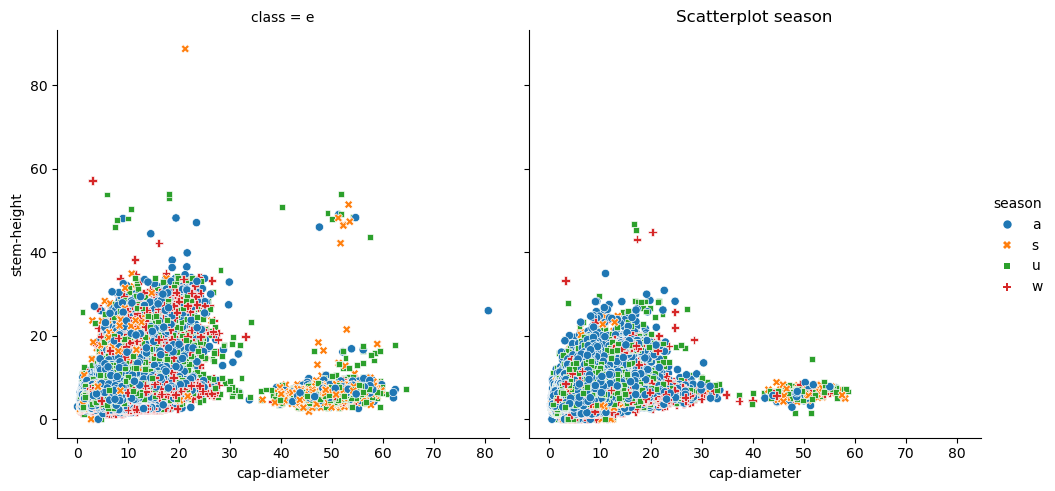

In [46]:
# Создаем список категориальных перменных не включая таргет
colm_cat = df_train.select_dtypes(include='category').columns.to_list()[1:]

# В цикле строим scatteplotы
for colm in tqdm(colm_cat):
    sns.relplot(data=df_train, x='cap-diameter', y='stem-height',
                hue=colm, style=colm, col='class', kind='scatter')
    plt.title(f'Scatterplot {colm}')

Какой-то логики не видно, любая категория может принимать любое значение в зависимости от диаметра или высоты. Предполагал, что некоторые категории имеют только определенный диаметр шапки и т.п.

Так как закономерностей найти не получилось, то заполним все пропуски заглушкой `unknown`. Пропуски в `cap-diameter` заполним медианой. 

## Работа с пропусками (продолжение)

In [14]:
# Заменяем пропуски медианной
df_train['cap-diameter'] = df_train['cap-diameter'].fillna(
    df_train['cap-diameter'].median())
df_test['cap-diameter'] = df_test['cap-diameter'].fillna(
    df_test['cap-diameter'].median())

In [15]:
# Заполняем пропуски модой
for col in df_test.select_dtypes(include='category').columns.to_list():
    df_train[col] = df_train[col].astype(
        'object').fillna('unknown').astype('category')
    df_test[col] = df_test[col].astype(
        'object').fillna('unknown').astype('category')

Проверим остались ли еще пропущенные значения.

In [49]:
df_train.isna().sum()  # Считаем пропуски

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [50]:
df_test.isna().sum()  # Считаем пропуски

id                      0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             1
stem-width              0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

## Исследование категориальных переменных (продолжение)

Посмотрим как соотносятся каждая категория с таргетом для этого построим столбчатые диаграммы по каждой категории.

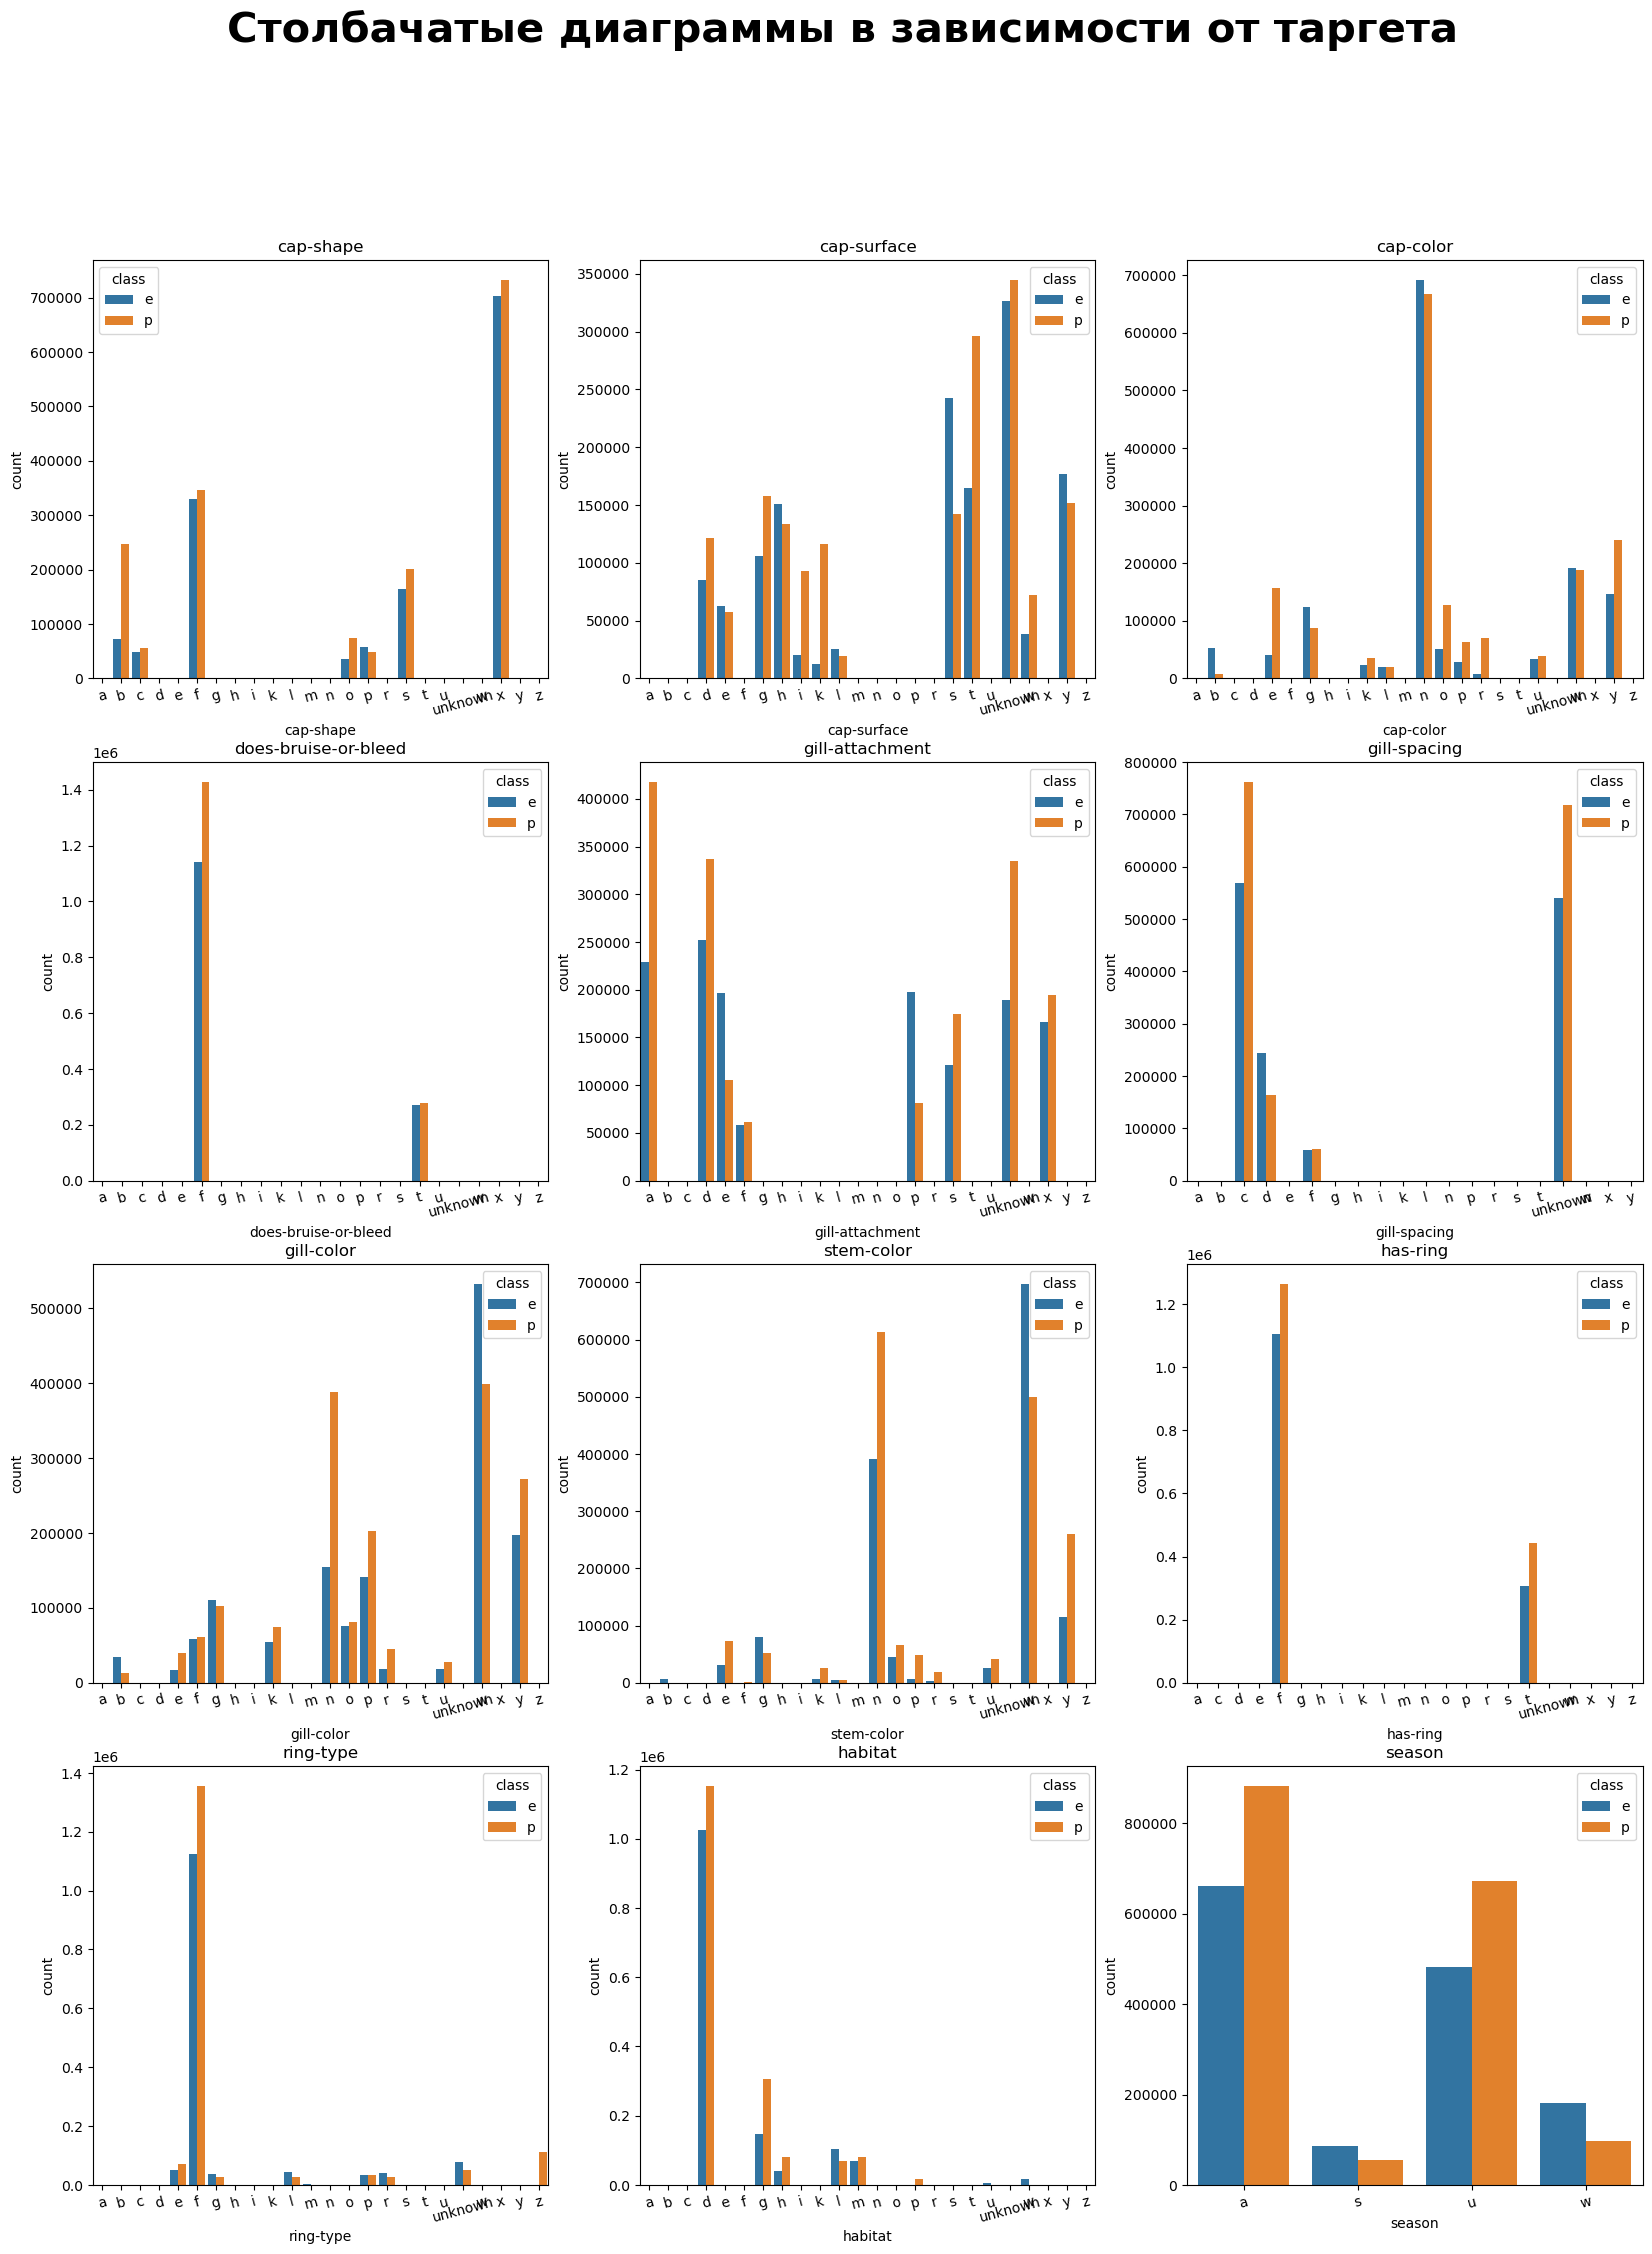

In [51]:
plt.figure(figsize=(20, 25))

plt.suptitle('Столбачатые диаграммы в зависимости от таргета',
             fontsize=30, fontweight='bold')

for number in range(len(colm_cat)):
    plt.subplot(4, 3, number+1)
    sns.countplot(x=colm_cat[number], data=df_train, hue='class')
    plt.xticks(rotation=15)
    plt.title(f'{colm_cat[number]}')

Видно, что некоторых категорий практически нет, возможно, в дальнейшем можно их объединить в одну категорию `other`. В целом соотношение класса по категории одинаковое. Где-то преобладает один класс где-то другой.

## Вывод

Провели исследование наших признаков. В результате выяснили, что соотношение таргета в целом одинаковое по всем категориям. В некоторых преобладает один класс, в некоторых другой. 

В данных были найдены аномальные значения (диаметр шапки, высота ножки и ширина ножки) после исследования информации в интернете, выяснили, что такие значения, которые мы получили в целом возможны, но очень редки. Решили выяснить сколько у нас таких значений и, если их очень мало то оставляем, так как они в целом очень редкие, если же их было бы много мы бы их заменили, предположив, что значения были указаны в другой системе измерения. По итогу удалять не стали. 

Все количественные признаки распределены ненормально, хотя по тесту Шапиро-Уилка `cap-diameter` показался нормально распределенным (при значениях > 5000, могут возникать ошибки), но был построен QQ-plot и по нему уже было видно, что данный признак имеет ненормальное распределение.  

Попытались найти закономерности между категориями  в зависимости от диаметра или высоты. Какой-то логики не нашли, любая категория может принимать любое значение, хотя ожидал, что некоторые категории имеют только определенный диаметр шапки и т.п.  Так как закономерностей найти не получилось, то заполнили все пропуски заглушкой `unknown`. Пропуски в `cap-diameter` заполнили медианой. Также были построены столбчатые диаграммы и заметили, что некоторых категорий практически нет и предположили, что в дальнейшем их можно объединить в одну категорию `other` (не стал так делать).

# Корреляционный анализ

Так как наши данные распределены ненормально и большинство из них является категориальными, поэтому, чтобы изучить взаимосвязи между ними, воспользуемся коэффициентом корреляции $\phi_k$ из библиотеки `phik`.

In [55]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_train.drop(columns='id').sample(50000).phik_matrix(
    interval_cols=df_train.select_dtypes(include='float').columns.to_list())

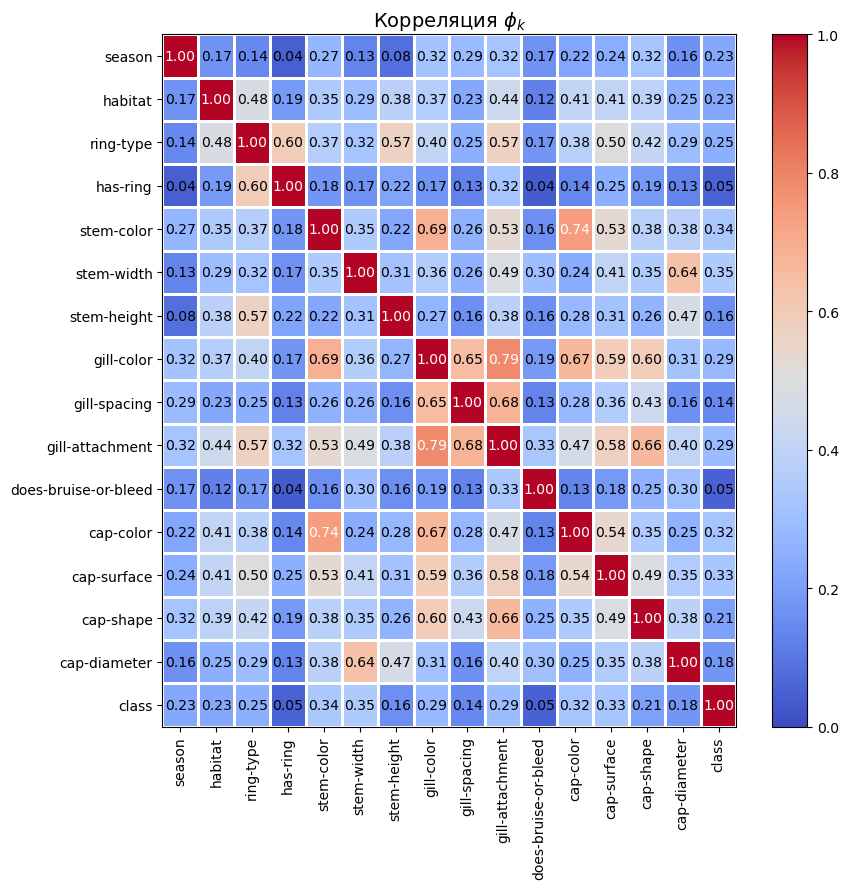

In [56]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1, figsize=(9, 9))

Таргет имеет со многими признаками слабую корреляцию. С признаками `has-ring` и `does-bruise-or-bleed` не имеет корреляции. Также эти два признака практически ни с кем не имеют корреляции. 
Между входными признаками мультиколлинеарности не наблюдается. Также можно отметить, что между некоторыми признаками присутствует хорошая взаимосвязь.

Между `gil-color` и `gil-attachment` сильная взаимосвязь - 0.79. Между `gil-color` и `stem-color` - 0.68, `gil-color` и `gil-spacing` - 0.65, `gil-color` и `cap-color` - 0.67, `gil-color` и `cap-surface` - 0.6, `gil-color` и `cap-shape` - 0.60.

Признак `gil-color` выглядит как очень важным, так как со многими имеет хорошую взаимосвязь.

`cap-diameter` и `stem-width` - 0.63, `cap-shape` и `gil-attachment` - 0.66, `cap-color` и `stem-color` - 0.73, `gil-attachment` и `gil-spacing` - 0.68, `gil-attachment` и `cap-shape` - 0.66, `ring-type` и `has-ring` - 0.6, `ring-type` и `stem-height` - 0.6

Признаки `does-bruise-or-bleed` и `season` удалим, так как они не имеют ни с кем взамосвязей.

In [16]:
# Удаляем признаки
df_train = df_train.drop(
    columns=['id', 'does-bruise-or-bleed', 'season'], axis=1)

In [58]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_test.drop(columns='id').sample(50000).phik_matrix(
    interval_cols=df_test.select_dtypes(include='float').columns.to_list())

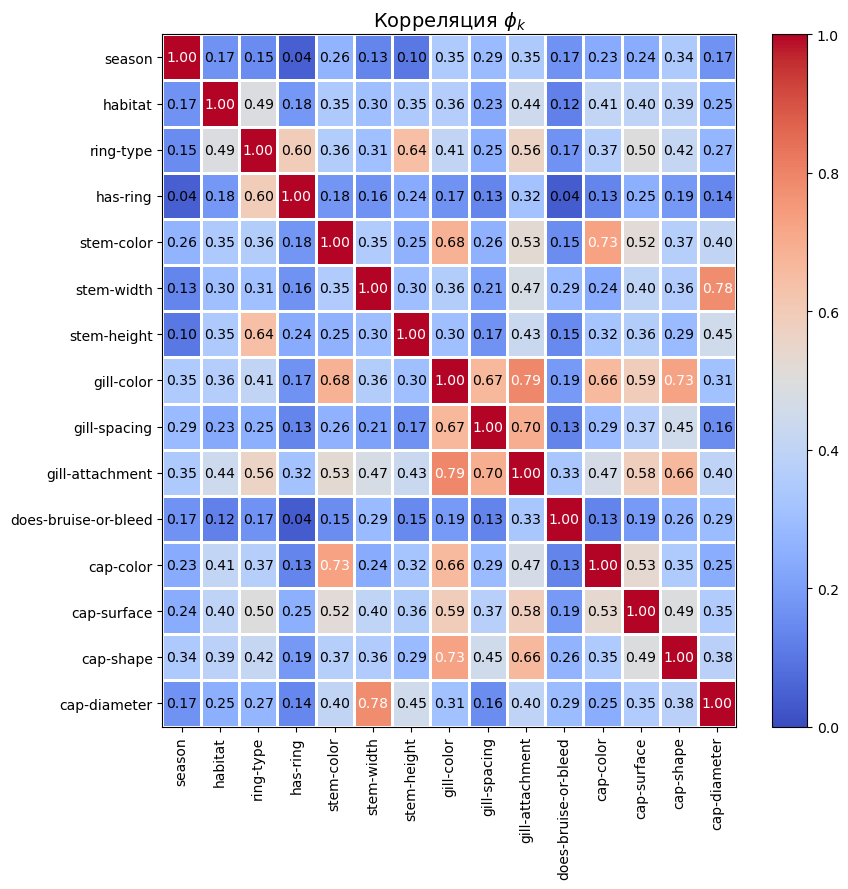

In [59]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1, figsize=(9, 9))

На тестовом датафрейме аналогичная ситуация.

In [17]:
# Удаляем признаки
df_test = df_test.drop(
    columns=['id', 'does-bruise-or-bleed', 'season'], axis=1)

# Обучение базовых моделей

Приступим к обучению модели. Перед нами стоит задача бинарной классификации наш целевой признак `class`. Перед обучением разделим данные на тестовые и тренировочные.

Сначала обучим базовые модели и из них выберем лучшую:

- `LogisticRegression`
- `LGBMClassifier`
- `DecisionTreeClassifier`
- `RandoForestClassifier`

Перед обучением необходимо будет закодировать и масштабировать признаки для этого воспользуемся `StandardScaler` - для числовых, `OneHotEncoder` для категориальных признаков. 


*Планировалось, что после того, как выберем лучшую модель для нее будем подберать гиперпараметры при помощи RandomizedSearchCV, так как мощности моего компьютера ограничены, но по итогу отказались из-за того, что улучшение модели не происходило.*

Оценивать модели будем по метрике MCC и accuracy.

In [18]:
X = df_train.drop(columns=['class'], axis=1)
y = df_train['class']

Посмотрим не появились ли дубликаты после отделения таргета

In [19]:
X.duplicated().sum()  # Проверяем на дубликаты

16453

In [20]:
X = X.drop_duplicates()  # Удаляем дубликаты

In [21]:
X = X.join(y, how='inner')  # Обьединяем таргет

In [22]:
X = X.reset_index(drop=True)  # Обновляем индексы

In [23]:
y = X['class']
X = X.drop(columns=['class'], axis=1)

In [24]:
X.duplicated().sum()  # Проверяем на дубликаты

0

In [25]:
# Разделяем данные на тренировочные и валидационные
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=y
)

Посмотрим на размеры выборок, чтобы убедиться, что все разбиение прошло правильно

In [69]:
X_train.shape, y_train.shape  # Проверяем размерность

((2325369, 13), (2325369,))

In [70]:
X_valid.shape, y_valid.shape  # Проверяем размерность

((775123, 13), (775123,))

Подготавливаем столбцы для пайплайна

In [26]:
# Создаём списки с названиями признаков
lab_col = ['class']
ohe_col = X_train.select_dtypes(include='category').columns.to_list()
num_col = X_train.select_dtypes(include='float').columns.to_list()

In [27]:
# Cоздаём пайплайн для подготовки признаков из списка ohe_col
ohe_pipe = Pipeline([('SimpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
                    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

In [28]:
# Cоздаём пайплайн для подготовки признаков из списка num_col
num_pipe = Pipeline([('SimpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='most_frequent', fill_value=0)),
                    ('num', StandardScaler())])

In [29]:
# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('num', num_pipe, num_col)],
    remainder='passthrough')

In [30]:
# Кодируем целевой признак
label_encode = LabelEncoder()

y_train_p = label_encode.fit_transform(y_train)
y_valid_p = label_encode.transform(y_valid)

In [31]:
# Пайплайн data_preprocessor применям к тренировочной, валидационной и тестовой выборкам
X_train_p = data_preprocessor.fit_transform(X_train)
X_valid_p = data_preprocessor.transform(X_valid)
X_test_p = data_preprocessor.transform(df_test)

Теперь обучим базовые модели

In [77]:
algs = [
    ['Решающее дерево', DecisionTreeClassifier(random_state=RANDOM_STATE)],
    ['Случайный лес', RandomForestClassifier(random_state=RANDOM_STATE)],
    ['Логистическая регрессия', LogisticRegression(random_state=RANDOM_STATE)],
    ['Градиентный бустинг', LGBMClassifier(
        random_state=RANDOM_STATE, verbosity=-1)]
]
for alg_name, classifier in tqdm(algs):
    classifier.fit(X_train_p, y_train_p)
    pred = classifier.predict(X_valid_p)
    mcc = matthews_corrcoef(y_valid_p, pred)
    acc = accuracy_score(y_valid_p, pred)
    print(f'{alg_name}: MCC-score: {mcc:.2f}, accuracy: {acc:.2f}')

  0%|          | 0/4 [00:00<?, ?it/s]

Решающее дерево: MCC-score: 0.96, accuracy: 0.98
Случайный лес: MCC-score: 0.98, accuracy: 0.99
Логистическая регрессия: MCC-score: 0.54, accuracy: 0.77
Градиентный бустинг: MCC-score: 0.97, accuracy: 0.99


In [78]:
del algs, pred
del classifier, acc, mcc
gc.collect()

49855

По итогу лучшая модель это случайный лес. В целом это ожидаемо, так как он устойчив к выбросам. Так как результаты метрик у случайного леса уже очень хороши, попробуем при помощи дерева решений найдем наиболее важные признаки, чтобы уменьшить их количество.

*p.s попробовал подобрать гиперпараметры для леса с помощью randomizedsearchcv, но в результате получалось либо хуже либо тоже самое, но при этом намного дольше расчет, поэтому от подбора гиперпараметров отказался, так как и базовая модель работает хорошо*

In [32]:
# Инициализируем и обучаем модель
dtc = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc.fit(X_train_p, y_train_p)

DecisionTreeClassifier(random_state=42)

Построим график важности признаков

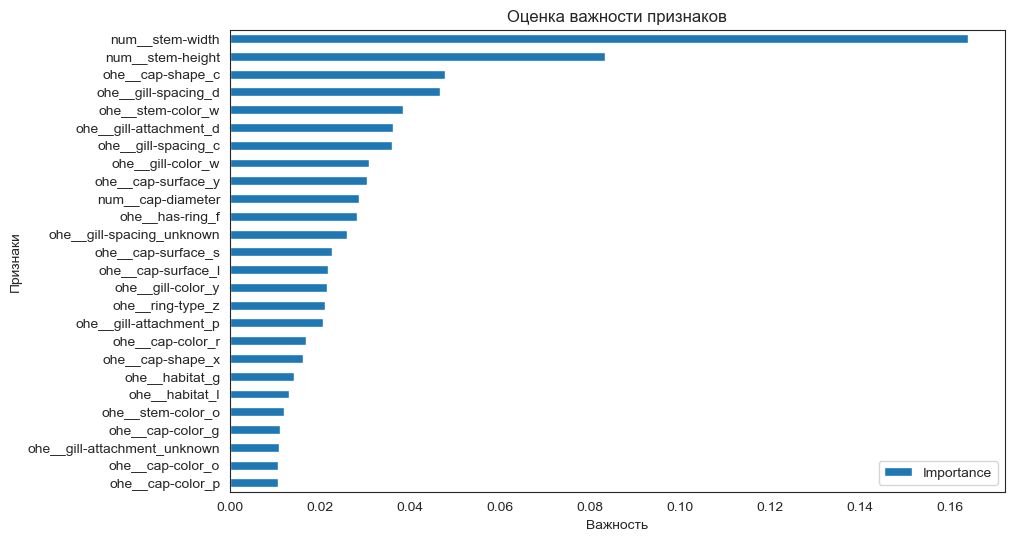

In [33]:
# Строим график важности
coefficients = dtc.feature_importances_

sns.set_style('white')
feature_importance = pd.DataFrame(
    {'Feature': data_preprocessor.get_feature_names_out(), 'Importance': np.abs(coefficients)})

feature_importance = feature_importance.sort_values(
    'Importance', ascending=False).reset_index(drop=True)

(
    feature_importance.loc[:25]
    .sort_values(by='Importance', ascending=True)
    .plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

)

plt.title('Оценка важности признаков')
plt.xlabel('Важность')
plt.ylabel('Признаки');

In [34]:
# Отбираем важные признаки (стало 141 вместо 224)
lead_feature = list(feature_importance[feature_importance['Importance']
                                  > 0]['Feature'].values)

In [35]:
# Создаем датафрейм со столбцами после применения 
X_train_p = pd.DataFrame(X_train_p, columns=data_preprocessor.get_feature_names_out())
X_valid_p = pd.DataFrame(X_valid_p, columns=data_preprocessor.get_feature_names_out())
X_test_p = pd.DataFrame(X_test_p, columns=data_preprocessor.get_feature_names_out())

In [36]:
del dtc
gc.collect()

15955

# Обучение лучшей базовой модели с меньшим количеством признаков

Обучим модель на меньшем количестве признаков. Делаем это, чтобы ускорить обучение.

In [84]:
# Инициализируем модель
rfc = RandomForestClassifier(
    random_state=RANDOM_STATE, 
    n_jobs=-1)

In [85]:
rfc.fit(X_train_p[lead_feature], y_train_p)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [86]:
y_pred_val = rfc.predict(X_valid_p[lead_feature])

In [87]:
print(
    f'Метрика accuracy на валидационной выборке: {accuracy_score(y_valid_p, y_pred_val):.2f}')

print(
    f'Метрика MCC на валидационной выборке: {matthews_corrcoef(y_valid_p, y_pred_val):.2f}')

Метрика accuracy на валидационной выборке: 0.99
Метрика MCC на валидационной выборке: 0.98


По итогу мы смогли сократить время, и при этом метрика осталась та же.

# Глубокое обучение

Так как подбор гиперпараметров не улучшал метрику, попробуем прибегнуть к глубокому обучению. Построим нейронную сеть с 6 скрытыми слоями и 50 эпохами. В качестве регуляризации будем использовать батч нормализацию. В качестве функции потерь используем кросс-энтропию. Оптимизатор Adam. Будем использовать ReduceLROnPlateau, если метрика не будет улучшаться будем уменьшать скорость обучения. Также реализована ранняя остановка.

In [37]:
# Переведем данные в тензор
X_train = torch.FloatTensor(X_train_p[lead_feature].values)
X_valid = torch.FloatTensor(X_valid_p[lead_feature].values)
X_test = torch.FloatTensor(X_test_p[lead_feature].values)
y_train = torch.FloatTensor(y_train_p)
y_valid = torch.FloatTensor(y_valid_p)

In [75]:
# Класс архетиктуры нейронной сети
class MushNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                 n_hidden_neurons_4, n_hidden_neurons_5, n_hidden_neurons_6,  n_out_neurons):
        super(MushNet, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.bn4 = nn.BatchNorm1d(n_hidden_neurons_4)

        self.fc5 = nn.Linear(n_hidden_neurons_4, n_hidden_neurons_5)
        self.bn5 = nn.BatchNorm1d(n_hidden_neurons_5)
        
        self.fc6 = nn.Linear(n_hidden_neurons_5, n_hidden_neurons_6)
        self.bn6 = nn.BatchNorm1d(n_hidden_neurons_6)

        self.fc7 = nn.Linear(n_hidden_neurons_6, n_out_neurons)

    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = torch.relu(out)

        out = self.fc2(out)
        out = self.bn2(out)
        out = torch.relu(out)

        out = self.fc3(out)
        out = self.bn3(out)
        out = torch.relu(out)

        out = self.fc4(out)
        out = self.bn4(out)
        out = torch.relu(out)

        out = self.fc5(out)
        out = self.bn5(out)
        out = torch.relu(out)
        
        out = self.fc6(out)
        out = self.bn6(out)
        out = torch.relu(out)

        out = self.fc7(out)
        out = torch.sigmoid(out)

        return out

In [76]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        '''
        Класс для реализации ранней остановки.
        '''
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

In [77]:
def neural_net(*args):
    '''
    Функция для обучения нейронной сети. На вход получает количество нейронов, 
    скорость обучения и выборки. Считает accuracy и mcc на валидационной 
    выборке и выводим предсказания на тестовой. Предусмотренна ранняя остановка.
    '''
    model = MushNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3,
                    n_hidden_neurons_4, n_hidden_neurons_5, n_hidden_neurons_6, n_out_neurons)  # Вызываем класс НС

    loss = nn.CrossEntropyLoss()  # В качестве функции потерь используем кросс-энтропию
    # Создаем Adam оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    patience = 25

    early_stopping = EarlyStopping(min_delta=0.01)  # Вызываем класс остановки

    reduce = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor=0.15, patience=patience, min_lr=1e-6)  # Уменьшим скорость обучения

    num_batches = ceil(len(X_train)/batch_size)

    # Цикл обучения
    for epoch in range(num_epochs):

        # Случайная перестановка объектов
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            start_index = batch_idx * batch_size

            model.train()
            optimizer.zero_grad()  # Обнуление градиентов

            batch_indexes = order[start_index:start_index+batch_size]
            X_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]

            preds = model.forward(X_batch).flatten()  # Прямое распространение
            loss_value = loss(preds, y_batch)

            loss_value.backward()
            optimizer.step()

        # Оценка на валидации
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                valid_preds = model.forward(X_valid).flatten()

                accuracy = torchmetrics.functional.accuracy(
                    valid_preds, y_valid, task='binary')  # Считаем accuracy

                mcc = torchmetrics.functional.matthews_corrcoef(
                    valid_preds, y_valid, num_classes=2, task='binary')  # Считаем mcc

            val_loss = loss(valid_preds, y_valid)  # Считаем loss

            print('Эпоха [{}/{}], Значение accuracy: {:.4f}, Значение mcc: {:.4f}'
                  .format(epoch+1, num_epochs, accuracy, mcc))

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print('Рання остановка!')
                break

            # Вызываем step для ReduceLROnPlateau
            reduce.step(val_loss)

    return model

In [78]:
# Задаем параметры НС
n_in_neurons = 141
n_hidden_neurons_1 = 256
n_hidden_neurons_2 = 128
n_hidden_neurons_3 = 64
n_hidden_neurons_4 = 32
n_hidden_neurons_5 = 16
n_hidden_neurons_6 = 8
n_out_neurons = 1
learning_rate = 0.001
num_epochs = 50
batch_size = 128

In [79]:
# Вызваем функцию обучения нейронной сети
model = neural_net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, 
                n_hidden_neurons_4, n_hidden_neurons_5, n_hidden_neurons_6, n_out_neurons, 
                learning_rate, X_train, X_valid, X_test, y_train, y_valid, num_epochs)

Эпоха [1/50], Значение accuracy: 0.9888, Значение mcc: 0.9774
Эпоха [11/50], Значение accuracy: 0.9906, Значение mcc: 0.9810
Эпоха [21/50], Значение accuracy: 0.9908, Значение mcc: 0.9814
Эпоха [31/50], Значение accuracy: 0.9909, Значение mcc: 0.9816
Эпоха [41/50], Значение accuracy: 0.9908, Значение mcc: 0.9815
Эпоха [50/50], Значение accuracy: 0.9909, Значение mcc: 0.9816


Результаты стали чуточку лучше как на валидации, так и на тесте. Хоть нейронная сеть и обучается дольше, чем обычная базовая модель случайного леса, но модель голубого обучения лучше для дальнейшего использования.

In [85]:
# Сохраним модель
torch.save(model, 'Mushrooms_neural_net.pth')

# Предсказания на тестовой

Раздел для предсказания на тесте для отправки на кагл.

In [88]:
# Загружаем модель
model = torch.load('Mushrooms_neural_net.pth')

In [89]:
model.eval()
with torch.no_grad():
    predictions = (model(X_test) > 0.5).flatten()

In [90]:
if os.path.exists(PTH3):
    submission = pd.read_csv(PTH3)
else:
    print('Файл не найден')

In [102]:
#X_test_p = data_preprocessor.transform(df_test)
#X_test_p = pd.DataFrame(X_test_p, columns=data_preprocessor.get_feature_names_out())
#y_test_pred = rfc.predict(X_test_p[lead_feature])

In [91]:
submission['class'] = np.where(predictions.detach().numpy() == 1, 'p', 'e')

In [92]:
# Сохраняем предсказания в файл
submission.to_csv('submission.csv', index=False)

# Вывод

Данные были получены из:

    - train.csv
    - test.csv
    - sample_submission.csv

В начале изучили данные. Все исследование проходило в 6 этапов.

1. Изучение данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Обучение базовых моделей
6. Глубокое обучение
7. Общий вывод

Перед нами стояла задача классификации. Оценить успешность ее выполнения требовалось по метрике Matthews correlation coefficient (MCC), также использовалась метрика accuracy.

**1. Изученние данных**

Так как у нас было очень много признаков, то вначале сразу выделили 7 наиболее важных признаков.

    Всего в тренировочном наборе 22 столбца, тип данных - int(1), object(18), float(3).
    Всего в тестовом наборе 21 столбец, тип данных - int(1), object(17), float(3).

Посмотрели на описательную статистику, в тренировочном наборе на первый взгляд не было ничего аномального, в тестовом же не понравились минимальные значения.

**2. Предобработка данных**

    Изменили типы данных для эффективного управления памятью. В результате удалось уменьшить потребление память в 5 раз.
    
    Сделали проверку на пропуски в данных. В результате увидели, что есть столбцы, у которых доля пропусков составляет больше 90%. Решили, что если доля пропусков больше 50%, то такие признаки мы удалим, так как восстановить данные не получиться, а заполнять их заглушкой нецелесообразно. Удалили 5 столбцов. Остальные пропуски пока оставили без изменений, так как, возможно, их получиться заполнить, если провести анализ.
    
    Сделали проверку на явные дубликаты. В результате они не были обнаружены.
    
    Сделали проверку на неявные дубликаты в категориальных столбцах. В результате проверки было обнаружено, что в данных есть множество категорий, которых не было в оригинальном датафрейме. Предположили, что, так как данные синтетические и были добавлены новые признаки, могли добавить и новые категории. Так как категории соответствуют буквам английского алфавита, то значения, которые не являются этими буквами заменяли на "моду" этого признака, для этого написали функцию `replace_unknown_val`.


**3. Исследовательских анализ данных**

    Соотношение таргета в целом одинаковое по всем категориям. В некоторых преобладает один класс, в некоторых другой. 

    В данных были найдены аномальные значения (диаметр шапки, высота ножки и ширина ножки) после исследования информации в интернете, выяснили, что такие значения, которые мы получили в целом возможны, но очень редки. Решили выяснить сколько у нас таких значений и, если их очень мало то оставляем, так как они в целом очень редкие, если же их было бы много мы бы их заменили, предположив, что значения были указаны в другой системе измерения. По итогу удалять не стали. 

    Все количественные признаки распределены ненормально, хотя по тесту Шапиро-Уилка `cap-diameter` показался нормально распределенным (при значениях > 5000, могут возникать ошибки), но был построен QQ-plot и по нему уже было видно, что данный признак имеет ненормальное распределение.  

    Попытались найти закономерности между категориями  в зависимости от диаметра или высоты. Какой-то логики не нашли, любая категория может принимать любое значение, хотя ожидал, что некоторые категории имеют только определенный диаметр шапки и т.п.  Так как закономерностей найти не получилось, то заполнили все пропуски заглушкой `unknown`. Пропуски в `cap-diameter` заполнили медианой. Также были построены столбчатые диаграммы и заметили, что некоторых категорий практически нет и предположили, что в дальнейшем их можно объединить в одну категорию `other` (не стал так делать).

**4. Корреляционный анализ**

    После анализа признаков приступили к исследованию взаимосвязи между ними и для расчета корреляции воспользовались корреляцией 𝜙𝑘. Так как значений в датасетах много, воспользовались функцией sample для создания репрезентативной выборки. 

    Таргет имеет со многими признаками слабую корреляцию. С признаками `has-ring` и `does-bruise-or-bleed` не имеет корреляции. Между входными признаками мультиколлинеарности не наблюдается. Также можно отметить, что между некоторыми признаками присутствует хорошая взаимосвязь.

    Признаки `does-bruise-or-bleed` и `season` удалим, так как они не имеют ни с кем взамосвязей.

**5. Обучение базовых моделей**

    У нас задача бинарной классификации, целевой признак - `class`. Разделили данные на тренировочные и валидационные. Кодирование и масштабирование производили в пайплайне. Использовали `OneHotEncoder` и `StandardScaler`. Обучали 4 базовых моделей.

    - `LogisticRegression`
    - `LGBMClassifier`
    - `DecisionTreeClassifier`
    - `RandoForestClassifier`

    По итогу лучшая модель это случайный лес. В целом это ожидаемо, так как он устойчив к выбросам. Так как результаты метрик у случайного леса уже очень хороши (MCC-score: 0.98, accuracy: 0.99), попробовали при помощи дерева решений найти наиболее важные признаки, чтобы уменьшить их количество. По итогу уменьшили их с 224 до 141 и обучили модель на меньшем количестве признаков. Метрики остались такие же.

**6. Глубокое обучение**

    Чтобы не останавливаться на базовой модели, решил воспользоваться глубоким обучением. Я использовал Pytorch. Написал два класса один для ранней остановки, другой класс архитектуры нейронной сети. Использовал 6 скрытых слоев и для регуляризации воспользовался батч нормализацией. Использовал оптимизатор Adam и ReduceLROnPlateau (чтобы уменьшать скорость обучения, если метрика не улучшается). Обучали НС на 50 эпохах с батчами. В качестве функции потерь использовали кросс-энтропию. В качестве функций активаций использовали ReLU и на последнем слое Sigmoid. Метрики взяли из torchmetrics. Результаты метрик стали чуточку лучше. Значение accuracy: 0.9909, Значение mcc: 0.9816.


**Вывод**

    В результате проекта была разработана модель глубокого обучения по классификации, является ли гриб ядовитый или нет. В начале использовали RandomForestClassifier и уже на базовой модели достигли отличных результатов. Улучшили результат используя глубокое обучение. 

    В дальнейшем проект можно улучшить выделив самые важные признаки, чтобы можно было определять ядовитость грибов зная меньше информации.